# Nexar Challenge 2
Re-Train it with nexar Dataset
<img src="nb_images/logo-nexar.png" width="50%">

In [1]:
import pandas as pd
from scipy import misc
import argparse
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.io
import scipy.misc
import os, sys
import shutil
import fnmatch
import math
import random, shutil
from PIL import Image
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from keras import optimizers
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from retrain_yolo import process_data,process_data_pil,get_classes,get_anchors,get_detector_mask,create_model,train,draw

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all" # importing iPython output fucntioanlity 

#sys.path.append(os.getcwd()+'/yad2k/models' )
#sys.path.append(os.getcwd()+'/yad2k/utils' )

from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body, yolo_eval
# from yad2k.utils.draw_boxes import draw_boxes

%matplotlib inline


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Definitons and paths

# path to images and boxes
images_dir = os.getcwd()+'/../data/Training/nexet_2017_'
boxes_dir = os.getcwd()+'/../data/Training/train_boxes.csv'

training_chunks_path = os.getcwd()+'/../data/Training/training_chunks/'
training_data_chunks_size = 8*30 # Number of samples of  chuncked downs training data files. Need to be multiple of smallest mini-batch to be used
training_chunks_name = 'training_chunk_'
images_test_dir = os.getcwd()+'/../data/Test/nexet_2017_test'

# anchors_path to anchors file, defaults to yolo_anchors.txt
anchors_path = "model_data/yolo_anchors.txt"

image_shape = (720., 1280.)

# Default anchor boxes
YOLO_ANCHORS = np.array(
    ((0.57273, 0.677385), (1.87446, 2.06253), (3.33843, 5.47434),
     (7.88282, 3.52778), (9.77052, 9.16828)))

# path to classes file, defaults to pascal_classes.txt
# Nexar classes ->
class_idx= {"car":1,"bus":2,"pickup_truck":3,"truck":4,"van":5}
classes_path = "model_data/nexar_classes.txt"

os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

# 1 - Preparing the data


To perform training we need:
* class_names,     anchors,      image_data,      boxes,     detectors_mask,      matching_true_boxes

Put the training data into a format: Data['class_names'], etc

We will load the original data, process it and save it into several npz (Data-chuncks) to perform mini-batches training.

Normal batches sizes are 8 and 32 samples, so we will make sure our data npz (Data-chuncks) are multiple of 8: 160 samples per chunk
  

In [3]:
# Get anchors and classes names
class_names = get_classes(classes_path)
anchors = get_anchors(anchors_path)

In [4]:
dts_images_names = []
for dts in range(1,4):
    print("Processing Dataset folder", dts)
    dts_files = os.listdir(images_dir+str(dts)) # files in dataset dts
    for i,image_sample in enumerate(dts_files): #for all images in the dataset folder
        dts_files[i] = images_dir+str(dts)+"/"+image_sample
    random.shuffle(dts_files) # Shuffle the order of data-chunks: Try to avoid biases
    dts_images_names.extend(dts_files)

Processing Dataset folder 1
Processing Dataset folder 2
Processing Dataset folder 3


In [7]:
# Custom dataset object 
images_list = []
boxes_list = []

# Load the train boxes
Img_db = pd.read_csv(boxes_dir, header = 0)

samples_to_chunk = 0
chunk_count = 1

random.shuffle(dts_images_names) # Shuffle the order of data-chunks: Try to avoid biases

for image_sample in dts_images_names: #for all images in the dataset folder
#     print(image_sample.split("/")[-1])

    ## Get original Images and Boxes
    # Get the image
    img2 = mpimg.imread(image_sample)
    images_list.append(img2)
    
    # Write the labels and boxes
    labels_boxes = []
#     print(Img_db[Img_db['image_filename']==image_sample.split("/")[-1]].as_matrix())
    for box_matched in Img_db[Img_db['image_filename']==image_sample.split("/")[-1]].as_matrix():
        labels_boxes.append( [class_idx[box_matched[-2]]-1, *box_matched[2:6]] )
    boxes_list.append(np.asarray(labels_boxes))

    samples_to_chunk +=1

    ## Translate to training model's inputs
    if(samples_to_chunk >= training_data_chunks_size or image_sample == dts_images_names[-1]):
        print(' Chunk number ',str(chunk_count))
        ### Preprocess the data: get images and boxes
        # get images and boxes
        image_data, boxes = process_data(images_list, boxes_list)
        print('     Chunked boxes data dimensions:', boxes.shape)
        image_data[0,:,:]
        print('     Chunked image data dimensions:',image_data.shape)
        ### Precompute detectors_mask and matching_true_boxes for training
        # Precompute detectors_mask and matching_true_boxes for training
        detectors_mask = [0 for i in range(len(boxes))]
        matching_true_boxes = [0 for i in range(len(boxes))]
        for i, box in enumerate(boxes):
            detectors_mask[i], matching_true_boxes[i] = preprocess_true_boxes(box, anchors, [416, 416])

        detectors_mask = np.array(detectors_mask)
        matching_true_boxes = np.array(matching_true_boxes)

        print("     detectors_mask shape     ",detectors_mask.shape)
        print("     matching_true_boxes shape",matching_true_boxes.shape)

        # Save
#         np.savez(training_chunks_path+training_chunks_name+str(chunk_count),
#                  class_names = class_names,
#                  anchors = anchors,
#                  image_data = image_data,
#                  boxes = boxes,
#                  detectors_mask = detectors_mask,
#                  matching_true_boxes = matching_true_boxes
#                 )
        chunk_count += 1
        # Remove data from RAM and update: Our problem is low RAM
        images_list = []
        boxes_list = []
        image_data = None
        boxes = None

        samples_to_chunk = 0
        # control
#             input("Press Enter to continue...")

 Chunk number  1
     Chunked boxes data dimensions: (240, 11, 5)
     Chunked image data dimensions: (240, 416, 416, 3)
     detectors_mask shape      (240, 13, 13, 5, 1)
     matching_true_boxes shape (240, 13, 13, 5, 5)
 Chunk number  2


KeyboardInterrupt: 

# 1 B - Data Generator

Get the datast location and create a callback that generates model inputs on demand

In [5]:
validation_split = 0.05
random.shuffle(dts_images_names) # Shuffle the order of data-chunks: Try to avoid biases
training_set_files = dts_images_names[0:math.ceil(len(dts_images_names)*(1-validation_split))]
val_set_files = dts_images_names[math.floor(len(dts_images_names)*(1-validation_split)):]


In [6]:
def get_batch(list_filenames, batch_size):
    Img_db = pd.read_csv(boxes_dir, header = 0)
    while True:
        for batches in range(len(list_filenames) // batch_size):
            images_list = []
            boxes_list = []
            image_data = None
            boxes = None
            for image_sample in list_filenames[batches*batch_size:min(len(list_filenames),(batches+1)*batch_size)]:
            
#                 images_list.append( mpimg.imread(image_sample)  )
                images_list.append( Image.open( image_sample )  )

                # Write the labels and boxes
                labels_boxes = []
                #     print(Img_db[Img_db['image_filename']==image_sample.split("/")[-1]].as_matrix())
                for box_matched in Img_db[Img_db['image_filename']==image_sample.split("/")[-1]].as_matrix():
                    labels_boxes.append( [class_idx[box_matched[-2]]-1, *box_matched[2:6]] )
                boxes_list.append(np.asarray(labels_boxes))
#             print(images_list[-1])
            ### Preprocess the data: get images and boxes
            # get images and boxes
            image_data, boxes = process_data_pil(images_list, boxes_list)
        
            ### Precompute detectors_mask and matching_true_boxes for training
            # Precompute detectors_mask and matching_true_boxes for training
            detectors_mask = [0 for i in range(len(boxes))]
            matching_true_boxes = [0 for i in range(len(boxes))]
            for i, box in enumerate(boxes):
                detectors_mask[i], matching_true_boxes[i] = preprocess_true_boxes(box, anchors, [416, 416])

            detectors_mask = np.array(detectors_mask)
            matching_true_boxes = np.array(matching_true_boxes)
            
            # yield x_batch, y_batch
            yield ( [image_data, boxes, detectors_mask, matching_true_boxes], np.zeros(len(image_data)) )

In [ ]:
for i in get_batch(training_set_files, 32):
#     print(i)
    pass


# 2 A - Training with Data Chunks

Train with the data processed and saved

We will iterate over all the chunked data to create true epochs and will use mini-batch training

We will use 2 different training steeps to steer the nerwork to our purpose,

In [7]:
# Wrap the Yolo model with other model for training: You can select how to wrpait and if you wnat to do transfer learning
# Create model around yolo model 
#     Use freeze_body for doing transfer learning on 1st training stage 
def create_model(anchors, class_names, load_pretrained=True, freeze_body=True):
    '''
    returns the body of the model and the model

    # Params:

    load_pretrained: whether or not to load the pretrained model or initialize all weights

    freeze_body: whether or not to freeze all weights except for the last layer's

    # Returns:

    model_body: YOLOv2 with new output layer

    model: YOLOv2 with custom loss Lambda layer

    '''

    detectors_mask_shape = (13, 13, 5, 1)
    matching_boxes_shape = (13, 13, 5, 5)

    # Create model input layers.
    image_input = Input(shape=(416, 416, 3))
    boxes_input = Input(shape=(None, 5))
    detectors_mask_input = Input(shape=detectors_mask_shape)
    matching_boxes_input = Input(shape=matching_boxes_shape)

    # Create model body.
    yolo_model = yolo_body(image_input, len(anchors), len(class_names))
    topless_yolo = Model(yolo_model.input, yolo_model.layers[-2].output)

    if load_pretrained:
        # Save topless yolo:
        topless_yolo_path = os.path.join('model_data', 'yolo_topless.h5')
        if not os.path.exists(topless_yolo_path):
            print("CREATING TOPLESS WEIGHTS FILE")
            yolo_path = os.path.join('model_data', 'yolo.h5')
            model_body = load_model(yolo_path)
            model_body = Model(model_body.inputs, model_body.layers[-2].output)
            model_body.save_weights(topless_yolo_path)
        topless_yolo.load_weights(topless_yolo_path)

    if freeze_body:
        for layer in topless_yolo.layers:
            layer.trainable = False
    final_layer = Conv2D(len(anchors)*(5+len(class_names)), (1, 1), activation='linear')(topless_yolo.output)

    model_body = Model(image_input, final_layer)

    # Place model loss on CPU to reduce GPU memory usage.
    with tf.device('/cpu:0'):
        # TODO: Replace Lambda with custom Keras layer for loss.
        model_loss = Lambda(
            yolo_loss,
            output_shape=(1, ),
            name='yolo_loss',
            arguments={'anchors': anchors,
                       'num_classes': len(class_names)})([
                           model_body.output, boxes_input,
                           detectors_mask_input, matching_boxes_input
                       ])

    model = Model(
        [model_body.input, boxes_input, detectors_mask_input,
         matching_boxes_input], model_loss)

    return model_body, model

In [8]:
chunks_files_names = fnmatch.filter(os.listdir( training_chunks_path  ), training_chunks_name+"*")
# Load just the first chunk 
data = np.load(training_chunks_path+'/'+chunks_files_names[2])
print("     I found ",data['image_data'].shape[0]," data samples on the data chunk")

     I found  3200  data samples on the data chunk


[[0.58277778 0.51976285 0.06333333 0.07509881 0.        ]
 [0.49555556 0.50395257 0.02       0.02371542 0.        ]
 [0.46555556 0.51778656 0.03555556 0.0513834  0.        ]
 [0.43111111 0.50395257 0.02       0.02766798 0.        ]
 [0.39722222 0.51383399 0.03666667 0.03952569 0.        ]
 [0.28111111 0.51778656 0.08222222 0.11462451 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


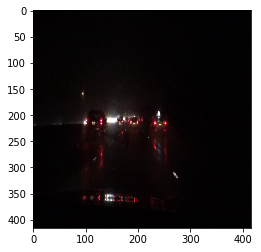

In [9]:
idx_test = 50
print( data['boxes'][idx_test] )
plt.imshow(data['image_data'][idx_test])
plt.show()

In [8]:
# Clear logs
shutil.rmtree(os.getcwd()+'/.logs')

## Training 1st pass: Transfer learning

In [10]:
### 1st pass: Transfer learning
number_true_epochs = 2
# Create the model
model_body, model = create_model(data['anchors'], data['class_names'], load_pretrained=True, freeze_body=True)

# Configure the training
model.compile(
        optimizer='adam', loss={
            'yolo_loss': lambda y_true, y_pred: y_pred
        })  # This is a hack to use the custom loss function in the last layer.

logging =  TensorBoard(log_dir='.logs', histogram_freq=1, batch_size=32, write_graph=True,
                                       write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
# run: $ tensorboard --logdir=.logs
validation_split = 0.05 # Do we really wanna do validation on each chunk?


In [11]:
### 1st pass: Transfer learning
for true_epoch in range(1,number_true_epochs+1):
    random.shuffle(chunks_files_names) # Shuffle the order of data-chunks: Try to avoid biases
    for chunk_file in chunks_files_names:
        print('      True epoch: '+str(true_epoch)+'/'+str(number_true_epochs))
        # Load the data
        data = np.load(training_chunks_path+'/'+chunk_file)
#         print("      Loading "+chunk_file+' with ',data['image_data'].shape[0]," data samples")
        
        # train the model
        model.fit([data['image_data'], data['boxes'], data['detectors_mask'], data['matching_true_boxes']],
                  np.zeros(len(data['image_data'])),
                  validation_split=validation_split,
                  batch_size=32,
                  epochs=1,
                  callbacks=[logging])
    
model.save_weights('trained_stage_1.h5')

      True epoch: 1/2
Train on 3040 samples, validate on 160 samples
Epoch 1/1
3040/3040 [==============================] - 31s 10ms/step - loss: 406.6783 - acc: 0.0000e+00 - val_loss: 199.6565 - val_acc: 0.0000e+00
      True epoch: 1/2
Train on 3040 samples, validate on 160 samples
Epoch 1/1
3040/3040 [==============================] - 29s 10ms/step - loss: 160.7024 - acc: 0.0000e+00 - val_loss: 162.4567 - val_acc: 0.0000e+00
      True epoch: 1/2


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-5ee6ce132855>", line 12, in <module>
    np.zeros(len(data['image_data'])),
  File "/usr/local/lib/python3.5/dist-packages/numpy/lib/npyio.py", line 235, in __getitem__
    pickle_kwargs=self.pickle_kwargs)
  File "/usr/local/lib/python3.5/dist-packages/numpy/lib/format.py", line 683, in read_array
    data = _read_bytes(fp, read_size, "array data")
  File "/usr/local/lib/python3.5/dist-packages/numpy/lib/format.py", line 822, in _read_bytes
    r = fp.read(size - len(data))
  File "/usr/lib/python3.5/zipfile.py", line 844, in read
    data = self._read1(n)
  File "/usr/lib/python3.5/zipfile.py", line 934, in _read1
    self._update_crc(data)
  File "/usr/lib/python3.5/zipfile.py", line 859, in _update_crc
    self._running_crc = crc32(newdata, self._running_crc)
Keyboa

TypeError: Can't convert 'list' object to str implicitly

In [10]:
model.save_weights('trained_stage_1.h5')

## Training: 2nd pass

In [9]:
### 2nd pass: Train all the model
number_true_epochs = 15
# Create the model
model_body, model = create_model(anchors, class_names, load_pretrained=False, freeze_body=False)
model.load_weights('trained_stage_1.h5')

# Configure the training
checkpoint = ModelCheckpoint("trained_stage_2_best.h5", monitor='val_loss',
                                     save_weights_only=True, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')

logging =  TensorBoard(log_dir='.logs', histogram_freq=1, batch_size=32, write_graph=True,
                                       write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
# run: $ tensorboard --logdir=.logs

optimizer = optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.0, amsgrad=False)

model.compile(
        optimizer = optimizer, loss={
            'yolo_loss': lambda y_true, y_pred: y_pred
        })  # This is a hack to use the custom loss function in the last layer.

validation_split = 0.05 # Do we really wanna do validation on each chunk?

In [10]:
for true_epoch in range(1,number_true_epochs+1):
    random.shuffle(chunks_files_names) # Shuffle the order of data-chunks: Try to avoid biases
    for chunk_file in chunks_files_names:
        print('      True epoch: '+str(true_epoch)+'/'+str(number_true_epochs))
        # Load the data
        data = np.load(training_chunks_path+'/'+chunk_file)
        print("      Loading "+chunk_file+' with ',data['image_data'].shape[0]," data samples")
        
        # train the model
        model.fit([data['image_data'], data['boxes'], data['detectors_mask'], data['matching_true_boxes']],
                  np.zeros(len(data['image_data'])),
                  validation_split=validation_split,
                  batch_size=32,
                  epochs=1,
                  callbacks=[logging, checkpoint, early_stopping])
        
model.save_weights('trained_stage_2.h5')

      True epoch: 1/15
      Loading training_chunk_7.npz with  3200  data samples
Train on 3040 samples, validate on 160 samples
Epoch 1/1
1248/3040 [===========>..................] - ETA: 45s - loss: 82.0861      True epoch: 1/15
      Loading training_chunk_14.npz with  3200  data samples
Train on 3040 samples, validate on 160 samples
Epoch 1/1
3040/3040 [==============================] - 68s 22ms/step - loss: 62.7267 - val_loss: 68.6462
      True epoch: 1/15
      Loading training_chunk_2.npz with  3200  data samples
Train on 3040 samples, validate on 160 samples
Epoch 1/1
3040/3040 [==============================] - 68s 22ms/step - loss: 59.0810 - val_loss: 57.8127
      True epoch: 1/15
      Loading training_chunk_5.npz with  3200  data samples
Train on 3040 samples, validate on 160 samples
Epoch 1/1
3040/3040 [==============================] - 69s 23ms/step - loss: 56.0939 - val_loss: 49.3359
      True epoch: 1/15
      Loading training_chunk_12.npz with  3200  data samples
T

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3040/3040 [==============================] - 68s 22ms/step - loss: 19.2141 - val_loss: 47.7597
      True epoch: 9/15
      Loading training_chunk_1.npz with  3200  data samples
Train on 3040 samples, validate on 160 samples
Epoch 1/1
3040/3040 [==============================] - 69s 23ms/step - loss: 19.6406 - val_loss: 54.5375
      True epoch: 10/15
      Loading training_chunk_5.npz with  3200  data samples
Train on 3040 samples, validate on 160 samples
Epoch 1/1
3040/3040 [==============================] - 69s 23ms/step - loss: 16.6460 - val_loss: 50.5852
      True epoch: 10/15
      Loading training_chunk_13.npz with  3200  data samples
Train on 3040 samples, validate on 160 samples
Epoch 1/1
3040/3040 [==============================] - 68s 22ms/step - loss: 16.6518 - val_loss: 56.1213
      True epoch: 10/15
      Loading training_chunk_10.npz with  3200  data samples
Train on 3040 samples, validate on 160 samples
Epoch 1/1
3040/3040 [==============================] - 68s 22ms/s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [11]:
model.save_weights('trained_stage_2.h5')

# 2 B - Training with Data Chunks

Train with the data generator

In [ ]:
# Clear logs
shutil.rmtree(os.getcwd()+'/.logs')

## Training 1st pass

In [56]:
### 1st pass: Transfer learning
number_epochs = 5
batch_size = 32
# validation_split = 0.05

# Create the model
model_body, model = create_model(anchors, class_names, load_pretrained=True, freeze_body=True)
# model.load_weights('trained_stage_1.h5')

# Configure the training
optimizer = optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.0, amsgrad=False)

model.compile(
        optimizer = optimizer, loss={
            'yolo_loss': lambda y_true, y_pred: y_pred
        })  # This is a hack to use the custom loss function in the last layer.

checkpoint = ModelCheckpoint("trained_stage_1_best.h5", monitor='val_loss',
                                     save_weights_only=True, save_best_only=True)
logging =  TensorBoard(log_dir='.logs', histogram_freq=0, batch_size=batch_size, write_graph=True,
                                       write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
# run: $ tensorboard --logdir=.logs

# train the model
model.fit_generator(get_batch(training_set_files, batch_size),
            steps_per_epoch=len(training_set_files) // batch_size,
             epochs = number_epochs, validation_data = get_batch(val_set_files, batch_size),
            validation_steps=len(val_set_files) // batch_size, callbacks= [logging,checkpoint])
    
model.save_weights('trained_stage_1.h5')

Epoch 1/2
1484/1484 [==============================] - 1887s 1s/step - loss: 62.6300 - val_loss: 57.7024
Epoch 2/2
1484/1484 [==============================] - 1887s 1s/step - loss: 127.8620 - val_loss: 187.6480


In [46]:
model.save_weights('trained_stage_1.h5')

## Training: 2nd pass

In [8]:
### 2nd pass: Train all the model
number_epochs = 20
batch_size = 32

# Create the model
model_body, model = create_model(anchors, class_names, load_pretrained=False, freeze_body=False)
model.load_weights('trained_stage_1.h5')

# Configure the training
checkpoint = ModelCheckpoint("trained_stage_2_best.h5", monitor='val_loss',
                                     save_weights_only=True, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')

logging =  TensorBoard(log_dir='.logs', histogram_freq=0, batch_size=batch_size, write_graph=True,
                                       write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
# run: $ tensorboard --logdir=.logs

optimizer = optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=1e-08, amsgrad=False)

model.compile(
        optimizer = optimizer, loss={
            'yolo_loss': lambda y_true, y_pred: y_pred
        })  # This is a hack to use the custom loss function in the last layer.


# train the model
model.fit_generator(get_batch(training_set_files, batch_size),
            steps_per_epoch=len(training_set_files) // batch_size,
             epochs = number_epochs, validation_data = get_batch(val_set_files, batch_size),
            validation_steps=len(val_set_files) // batch_size, 
                    callbacks=[logging, checkpoint, early_stopping])
model.save_weights('trained_stage_2.h5')

Epoch 1/20
 230/1484 [===>..........................] - ETA: 25:09 - loss: 94.4909

IndexError: index 20 is out of bounds for axis 1 with size 13

## 3 Evaluate (Validate) the training

In [57]:
## Evaluating

# Create the model again??: Do it if not loaded
model_body, model = create_model(anchors, class_names, load_pretrained=False, freeze_body=False)

sess = K.get_session()

# Load the weights of the last trained model onto the loaded model(model_body: YOLO model)
model_body.load_weights('trained_stage_1.h5')
# model_body.load_weights('trained_stage_2_best.h5')
# model_body.load_weights('trained_stage_2.h5')

In [58]:
model_body.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
conv2d_121 (Conv2D)             (None, 416, 416, 32) 864         input_21[0][0]                   
__________________________________________________________________________________________________
batch_normalization_111 (BatchN (None, 416, 416, 32) 128         conv2d_121[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_111 (LeakyReLU)     (None, 416, 416, 32) 0           batch_normalization_111[0][0]    
__________________________________________________________________________________________________
max_poolin

Before modifications, Original YOLO model had a head (Output tensors):

* (<tf.Tensor 'truediv_2:0' shape=(?, ?, ?, 5, 2) dtype=float32>,
* <tf.Tensor 'truediv_3:0' shape=(?, ?, ?, 5, 2) dtype=float32>,
*  <tf.Tensor 'Sigmoid_1:0' shape=(?, ?, ?, 5, 1) dtype=float32>,
* <tf.Tensor 'Reshape_7:0' shape=(?, ?, ?, 5, 80) dtype=float32>)

Now, since we redisigned the output layer (2D convolution) for other classes, the output classes count would be diferrent 

In [59]:
yolo_outputs = yolo_head(model_body.output, anchors, len(class_names))
yolo_outputs

(<tf.Tensor 'truediv_58:0' shape=(?, ?, ?, 5, 2) dtype=float32>,
 <tf.Tensor 'truediv_59:0' shape=(?, ?, ?, 5, 2) dtype=float32>,
 <tf.Tensor 'Sigmoid_33:0' shape=(?, ?, ?, 5, 1) dtype=float32>,
 <tf.Tensor 'Reshape_131:0' shape=(?, ?, ?, 5, 5) dtype=float32>)

In [60]:
input_image_shape = K.placeholder(shape=(2, ))
input_image_shape

<tf.Tensor 'Placeholder_668:0' shape=(2,) dtype=float32>

In [61]:
def predict_any(sess , model, image_file, anchors, class_names, max_boxes, score_threshold, iou_threshold):

    # Get head of model
    yolo_outputs_ = yolo_head(model.output, anchors, len(class_names))
    
    # Preprocess your image
    model_image_size =  model.inputs[0].get_shape().as_list()[-3:-1]
    image, image_data = preprocess_image(image_file, model_image_size =  model_image_size )
    
    img=plt.imread(image_file)
    img_shape_ = img.shape[0:2]
    print(  "Reshaping input image "+str( img_shape_)  +" to model input shape "+str(model_image_size)  )
    
    # Get the Tensors
    boxes, scores, classes = yolo_eval(yolo_outputs_, [float(i) for i in list(img_shape_)],
                max_boxes,
              score_threshold,
              iou_threshold)  

    # Run the session with the correct tensors and choose the correct placeholders in the feed_dict.
    # You'll need to use feed_dict={model.input: ... , K.learning_phase(): 0})
    ### START CODE HERE ### (≈ 1 line)
    out_boxes, out_scores, out_classes = sess.run(
            [boxes, scores, classes],
            feed_dict={
                model.input: image_data,
                input_image_shape: [image_data.shape[2], image_data.shape[3]],
                K.learning_phase(): 0
            })
    ### END CODE HERE ###

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file.split('/')[-1]), quality=90)
    # Display the results in the notebook
    plt.figure()

    output_image = scipy.misc.imread(os.path.join("out", image_file.split('/')[-1]))
    plt.imshow(output_image)

    return out_scores, out_boxes, out_classes

Reshaping input image (720, 1280) to model input shape [416, 416]
Found 3 boxes for /dtorres1/Desktop/Nexar_challenge_2/src/../data/Training/nexet_2017_1/frame_00ca4fbc6a80b6c8e1e3daf170b85651_2c03934902d21ae8b57b6be1cb020f9e_0-1280_720.jpg
car 0.66 (546, 388) (577, 414)
car 0.85 (945, 381) (1050, 480)
car 0.90 (388, 392) (456, 446)


<Figure size 432x288 with 0 Axes>

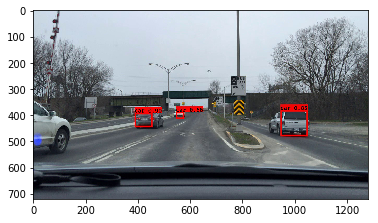

In [68]:
dts_files = os.listdir(images_dir+str(1))
plt.figure()
out_scores, out_boxes, out_classes = predict_any(sess, model_body,
                                                 val_set_files[ np.random.randint(0,high=len(val_set_files)) ],
                                                 anchors, class_names,
                                                max_boxes=10,
                                                  score_threshold=.6,
                                                      iou_threshold = 0.4)